In [16]:
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [313]:
# size of around 400 images per class would be ideal

In [17]:
master_dataset = tf.keras.utils.image_dataset_from_directory(
    '../../data/trashnet/dataset-resized',
    labels='inferred',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 2527 files belonging to 6 classes.


In [18]:
class_names = master_dataset.class_names

In [19]:
def load_class_dataset(master_dataset, class_index, augment=False, num_samples=None):
    dataset = (master_dataset.unbatch()).filter(lambda x, y: tf.equal(y, class_index))

    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"), # apply augmentation only if we have to make more images
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.1)
        ])
        dataset = dataset.map(lambda x, y: (aug(x, training=True), y))

    if num_samples is not None:
        dataset = dataset.shuffle(buffer_size=num_samples, seed=123).repeat().take(num_samples)
    return dataset.batch(32)

In [20]:
batched_dataset = []
counts = [403, 501, 482, 594, 410, 137]
target_size = 400

for i, count in enumerate(counts):
    # need to cut out some of the images
    batched_dataset.append(load_class_dataset(master_dataset, i, count < target_size, target_size))

balanced_dataset = batched_dataset[0]
for dataset in batched_dataset[1:]:
    balanced_dataset = balanced_dataset.concatenate(dataset)

In [21]:
total_samples = target_size * len(class_names)
shuffled = balanced_dataset.unbatch().shuffle(total_samples, seed=123)

In [22]:
train_dataset = (
    shuffled.take(int(0.7 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    shuffled.skip(int(0.7 * total_samples)).take(int(0.2 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    shuffled.skip(int(0.9 * total_samples)).take(int(0.1 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    #tf.keras.layers.RandomFlip('horizontal', input_shape=(512, 256, 3)),
    #tf.keras.layers.RandomRotation(0.2),
    #tf.keras.layers.RandomZoom(0.2),
    #tf.keras.layers.RandomBrightness(0.2),
    #tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)), # rescale the layer to fit within the 0-1 threshold
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.15),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [24]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    11,075,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,106,022 (42.37 MB)

 Trainable params: 11,106,022 (42.37 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
checkpoint_dir = '../models/'

In [27]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}.weights.h5"),
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

In [28]:
fitted_model = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    callbacks=[checkpoint_cb]
)

Epoch 1/5
     53/Unknown 15s 170ms/step - accuracy: 0.2051 - loss: 2.2273
Epoch 1: val_accuracy improved from -inf to 0.42708, saving model to ../models/epoch_01.weights.h5
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - accuracy: 0.2064 - loss: 2.2198 - val_accuracy: 0.4271 - val_loss: 1.4536
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4785 - loss: 1.4018
Epoch 2: val_accuracy improved from 0.42708 to 0.43958, saving model to ../models/epoch_02.weights.h5
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.4788 - loss: 1.4009 - val_accuracy: 0.4396 - val_loss: 1.4081
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5529 - loss: 1.2089
Epoch 3: val_accuracy improved from 0.43958 to 0.64375, saving model to ../models/epoch_03.weights.h5
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.5538 - loss: 1.2066 - val_accuracy: 0.6438 - val_loss: 1.0300
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6519 - loss: 0.9532
Epoch 4: val_a

2025-07-01 21:12:48.777422: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7365 - loss: 0.7336
Epoch 5: val_accuracy improved from 0.68958 to 0.70417, saving model to ../models/epoch_05.weights.h5
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.7372 - loss: 0.7322 - val_accuracy: 0.7042 - val_loss: 0.8834


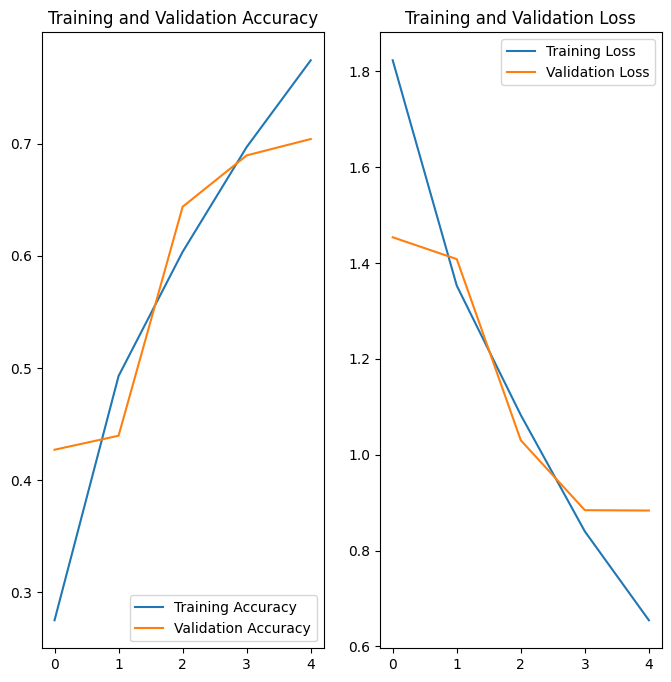

In [30]:
acc = fitted_model.history['accuracy']
val_acc = fitted_model.history['val_accuracy']

loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
img = Image.open('../../data/test/cardboard_test.jpeg').resize((224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(score.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
This image most likely belongs to cardboard with a 35.21 percent confidence.
[0.3521422  0.12956895 0.12956962 0.12956728 0.12957117 0.12958081]


In [33]:
eval_result = model.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7103 - loss: 0.8229
[test loss, test accuracy]: [0.8033371567726135, 0.7083333134651184]


/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [34]:
model.save('../models/model.keras')

In [330]:
# next step would be to hyperparameter tune and see if i can find better parameters